## Setup enviroment

In [1]:
import os
import gc
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss
import joblib
from venn_abers import VennAbersCalibrator
import sys
sys.path.append(r'/home/jeanlr/projetos/lending-club/global')
from util import *
import json

/home/jeanlr/projetos/lending-club/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the calibration data

In [2]:
train_df = pd.read_parquet('../data/processed/abt_train.parquet')
validation_df = pd.read_parquet('../data/processed/abt_validation.parquet')
calibration_df = pd.read_parquet('../data/processed/abt_calibration.parquet')

In [3]:
categorical_column_names = train_df.select_dtypes(include=['category']).columns
categorical_column_names

Index(['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type'],
      dtype='object')

In [4]:
cat_features = ['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type']

In [5]:

target = 'default'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (86641, 100) (86641,)
Validation shape:  (246072, 100) (246072,)
Calibration shape:  (61519, 100) (61519,)


## Loading models

In [6]:
# Base model
# Load the baseline and feature selection models
baseline_model_path = '../artifacts/baseline_model.joblib'
feat_selection_model_path = '../artifacts/feat_selection_model.joblib'
tunned_model_path = '../artifacts/tunned_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)
tunned_model = joblib.load(tunned_model_path) 

champion_model = feat_selection_model

In [7]:
selected_features = None
with open('../artifacts/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'income_to_funded_ratio', 'debt_to_income_ratio', 'funded_amnt_per_income', 'fico_avg', 'int_rate_to_income_ratio', 'pct_active_bc', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'application_type']


## Calibrate the model using Platt scaling (sigmoid) and isotonic regression

In [8]:
# Platt scaling (sigmoid)
print('Fitting platt scaling calibration...')
calibrated_model_sigmoid = CalibratedClassifierCV(champion_model, method='sigmoid')
calibrated_model_sigmoid.fit(X_calibration[selected_features], y_calibration)
y_pred_sigmoid = calibrated_model_sigmoid.predict_proba(X_validation[selected_features])[:, 1]

Fitting platt scaling calibration...
0:	learn: 0.6903597	total: 78.3ms	remaining: 1m 18s
1:	learn: 0.6874318	total: 109ms	remaining: 54.2s
2:	learn: 0.6848245	total: 137ms	remaining: 45.4s
3:	learn: 0.6820370	total: 167ms	remaining: 41.6s
4:	learn: 0.6795129	total: 197ms	remaining: 39.1s
5:	learn: 0.6771565	total: 220ms	remaining: 36.5s
6:	learn: 0.6748825	total: 247ms	remaining: 35s
7:	learn: 0.6723983	total: 273ms	remaining: 33.9s
8:	learn: 0.6700852	total: 302ms	remaining: 33.2s
9:	learn: 0.6678055	total: 333ms	remaining: 33s
10:	learn: 0.6657458	total: 356ms	remaining: 32s
11:	learn: 0.6640106	total: 372ms	remaining: 30.6s
12:	learn: 0.6621688	total: 394ms	remaining: 29.9s
13:	learn: 0.6604572	total: 422ms	remaining: 29.7s
14:	learn: 0.6587583	total: 470ms	remaining: 30.9s
15:	learn: 0.6572995	total: 498ms	remaining: 30.6s
16:	learn: 0.6560545	total: 523ms	remaining: 30.2s
17:	learn: 0.6544344	total: 549ms	remaining: 29.9s
18:	learn: 0.6528457	total: 568ms	remaining: 29.3s
19:	lear

In [9]:
# Compute metrics for Platt scaling and isotonic regression
print("Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.727338884325454
Brier Score: 0.1419047799031744
Average Precision: 0.40528319587097317
Log Loss: 0.4456834295512924


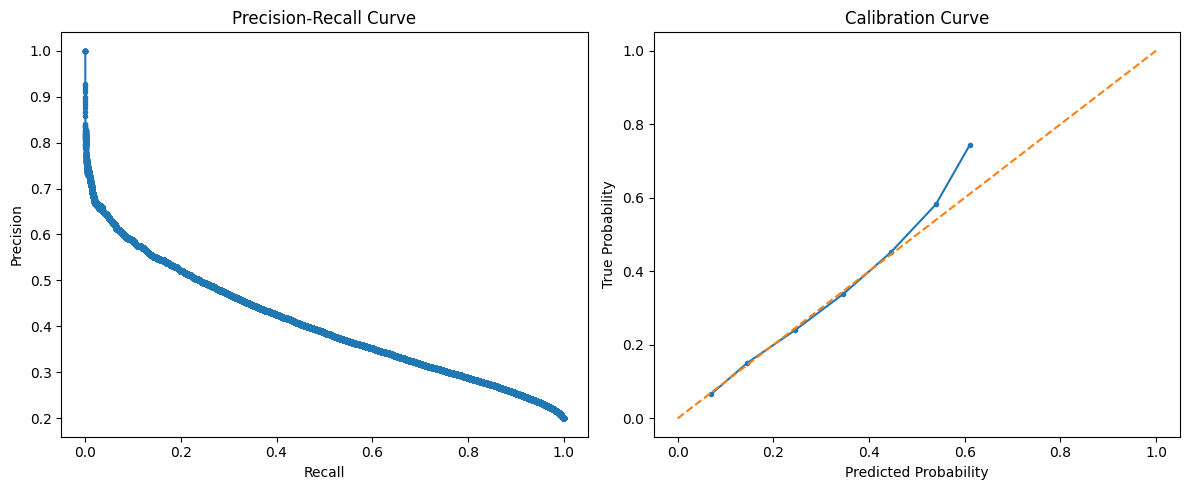

In [10]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_sigmoid, y_validation)

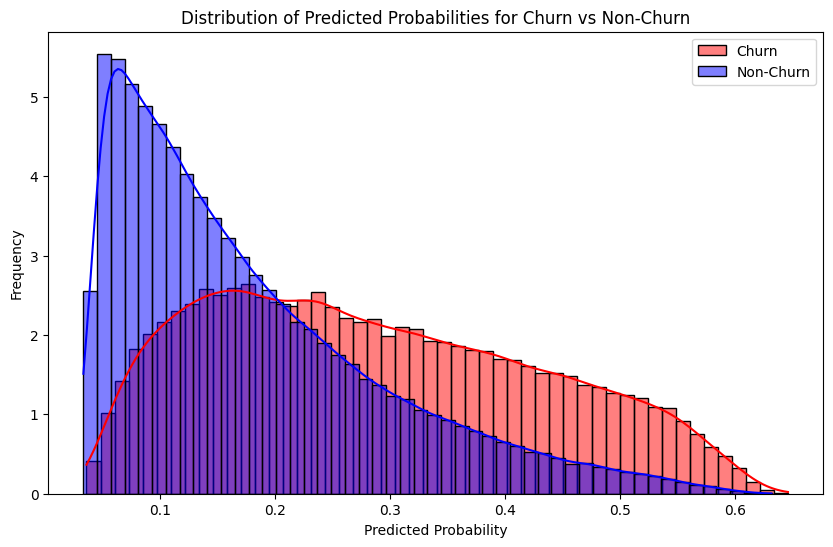

In [11]:
plot_dis_probs(y_pred_sigmoid, y_validation)

## Calibrate the model using Venn-Abers

In [12]:
p_cal = tunned_model.predict_proba(X_calibration[selected_features])
p_test = tunned_model.predict_proba(X_validation[selected_features])

va = VennAbersCalibrator()
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_test)
y_pred_va = va_prefit_prob[:, 1]

/home/jeanlr/projetos/lending-club/.venv/lib/python3.12/site-packages/venn_abers/venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


In [13]:
# Compute metrics for Venn-Abers calibration
print("\nVenn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)


Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.7050338708896114
Brier Score: 0.14540860803635103
Average Precision: 0.3625646164320271
Log Loss: 0.4565427925502022


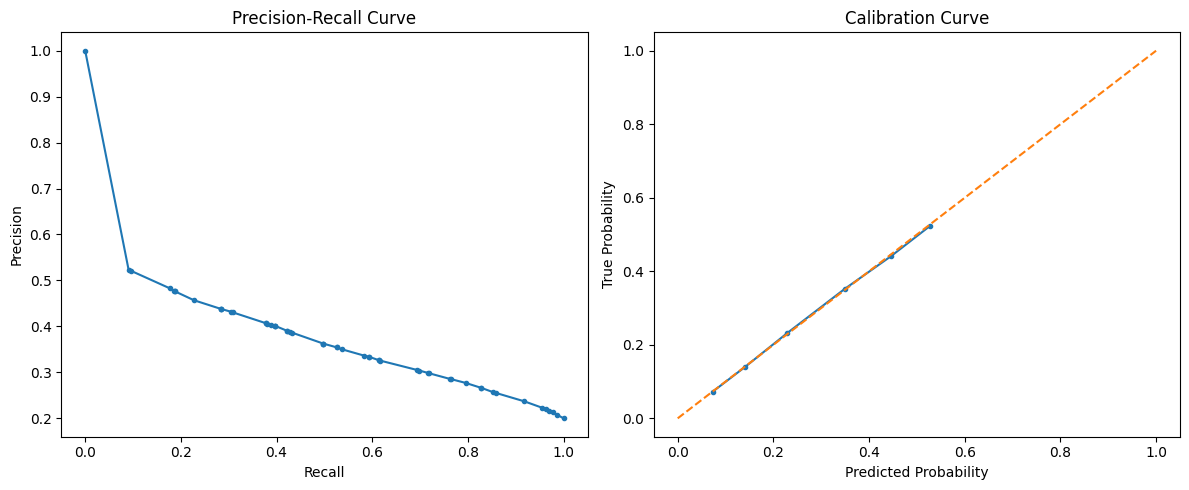

In [14]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_va, y_validation)

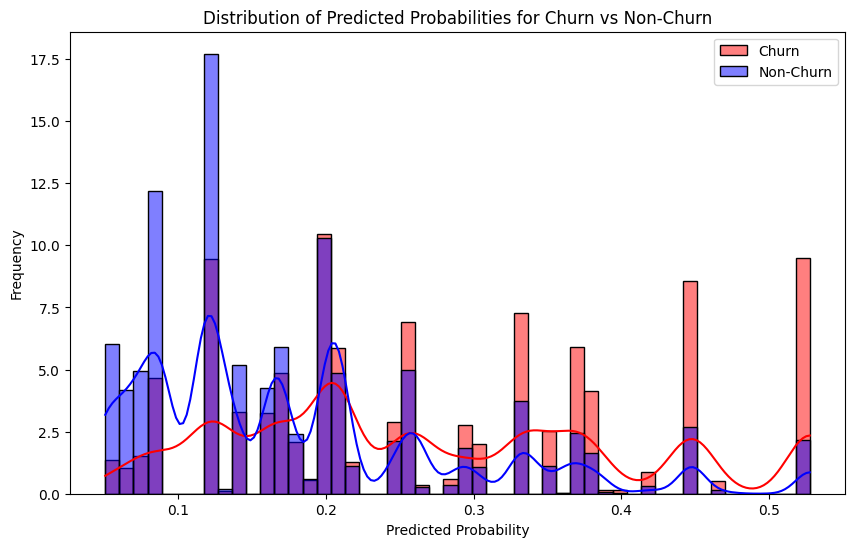

In [15]:
plot_dis_probs(y_pred_va, y_validation)

## Compare the models

In [16]:
# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]

# Predict using the tunned model
y_pred_tunned= tunned_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

print("\nChampion Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nnChampion Venn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)


Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.7238451070139131
Brier Score: 0.20820810891560274
Average Precision: 0.3991167263291786
Log Loss: 0.6012544039511277

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.7251291424019894
Brier Score: 0.19985954452561816
Average Precision: 0.40147491164752813
Log Loss: 0.5827367168790695

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.7050152686823198
Brier Score: 0.2455646221464021
Average Precision: 0.3671236779086463
Log Loss: 0.6842744249146548

Champion Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.727338884325454
Brier Score: 0.1419047799031744
Average Precision: 0.40528319587097317
Log Loss: 0.4456834295512924

nChampion Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.7050338708896114
Brier Score: 0.14540860803635103
Average Precision: 0.3625646164320271
Log Loss: 0.4565427925502022


In [17]:
# Caminho para salvar o modelo
model_path = "../artifacts/calibrated_model_sigmoid.pkl"

# Salvando o modelo treinado
joblib.dump(calibrated_model_sigmoid, model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em ../artifacts/calibrated_model_sigmoid.pkl
